In [2]:
import os

import scipy.io as sio
from scipy.io import readsav
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import emcee
from astropy.io import fits
from collections import Counter
import radvel

from residual_plot import residual_plot
from Least_sq_fit import Least_sq_fit
from Weighted_LS_fit import Weighted_LS_fit
from Weighted_LS_fit_with_h_alpha import Weighted_LS_fit_with_h_alpha
from Weighted_LS_fit_fwhm_BIS import Weighted_LS_fit_fwhm_BIS
from Weighted_LS_fit_with_h_alpha_AND_planet import Weighted_LS_fit_with_h_alpha_AND_planet
from results_compare_ccf_plot import results_compare_ccf_plot
from overfitting_checks import overfitting_checks
from fwhm_sigma import fwhm_sigma
from BIC import BIC

plt.rcParams['font.size'] = 15
#plt.style.use("seaborn-dark")
#for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
#    plt.rcParams[param] = '#212946'  # bluish dark grey
#for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
#    plt.rcParams[param] = '0.9'  # very light grey


In [9]:
star_name = '10700'#'101501'#34411# '26965', '10700'
file_end = 'prov_rvs' #"best_fit"#"best_fit" #"prov_rvs"#or 

hdul_open = fits.open('HD'+star_name+'/binned_ccfs/binned_ccfs_'+file_end+'_with_s_halpha.fits', memmap=False)
wls = hdul_open[1].data['wls']
ccf_list = hdul_open[1].data['binned_ccfs']#[8:]
ccf_list = ccf_list - np.median(ccf_list, axis=0)
median_residual = np.median(ccf_list, axis=0)
std_residual = np.std(ccf_list, axis=0)
rescaled_resids = (ccf_list-median_residual)/std_residual

bjd_list = hdul_open[2].data['bjd']#[8:]

if file_end =="best_fit":
    rv_list = hdul_open[2].data['mu_og_list']
else:
    rv_list = hdul_open[2].data['vrad_star']

#rv_list = hdul_open[2].data['vrad_star']# hdul_open[2].data['mu_og_list'] # [8:] #hdul_open[2].data['mu_og_list'][8:] #
rv_error = hdul_open[2].data['svrad_star']#[8:]
#night_e = hdul_open[2].data['night_e']
s_index = hdul_open[2].data['s_index']
h_alpha = hdul_open[2].data['h_alpha']
BIS = hdul_open[2].data['BIS']
fwhm = hdul_open[2].data['fwhm']

# create pandas dataframe
df = pd.DataFrame(list(zip(bjd_list, rv_list, rv_error, rescaled_resids, s_index, h_alpha, BIS, fwhm)), 
                  columns=["BJD","vrad", "svrad", "CCF", "s_index", "h_alpha", "BIS", "fwhm"])
df_sorted = df.sort_values(by=['BJD']) 

print("number of nights: "+str(len(bjd_list)))

number of nights: 34


In [10]:
# format data for LS fit
rv_np = np.array(list(df_sorted["vrad"]-np.mean(df_sorted["vrad"])))*1000
s_rv_np = np.array(list(df_sorted["svrad"]))*1000
#night_e_np = np.array(list(df_sorted["night_e"]))*1000
#s_index_np = np.array([list(df_sorted["s_index"])])
h_alpha_np = np.array([list(df_sorted["h_alpha"]-np.mean(df_sorted["h_alpha"]))])*1000
fwhm_np =  np.array([list(df_sorted["fwhm"])])


ccf_list_np = np.array(list(df_sorted["CCF"]))
ccf_list_np_transpose = ccf_list_np.transpose()
ccf_list_np_transpose_extra_info = np.append(ccf_list_np_transpose, h_alpha_np, axis=0)


time_np = np.array(df_sorted["BJD"])-np.min(df_sorted["BJD"])
h_alpha_np

array([[ 1.18479834,  1.00820468, -0.84345832,  1.1701505 ,  3.1232606 ,
        -0.57851567,  0.00794933,  0.90023086, -1.47826268, -4.37206819,
         0.69888637, -0.03781213,  0.11654899,  1.11036704,  1.11334727,
         0.10042594,  1.71158419, -0.24249448,  1.01632581,  0.51466332,
        -1.14543035, -1.03352263, -0.1451154 ,  0.17907427, -0.15120997,
        -0.69587722, -0.08834197, -4.48533191, -2.49313607,  0.91137693,
         1.5205364 ,  0.18288896,  1.11437545,  0.10558174]])

0.0 1.0


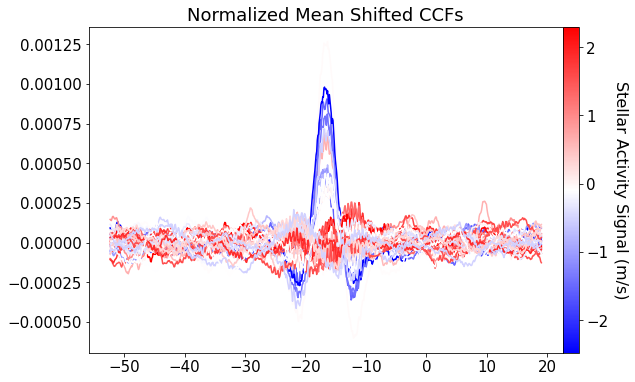

In [11]:
residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "Normalized Mean Shifted CCFs")

Text(0, 0.5, 'RV (m/s)')

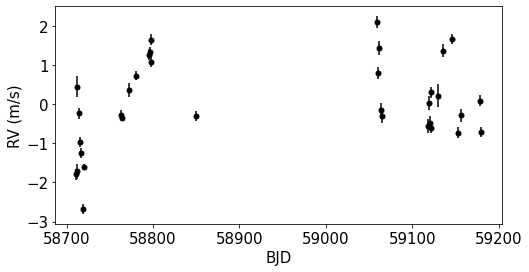

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))

x = df_sorted["BJD"]
y = rv_np
yerr = s_rv_np

#ax[0].scatter(txt_file["BJD_UTC"]-2400000, txt_file["vrad"]-np.mean(txt_file["vrad"]))
ax.errorbar(x, y, yerr = yerr, fmt = 'o', color='k')
ax.set_xlabel("BJD", size=15)
ax.set_ylabel("RV (m/s)",size=15)


0.7369051579898784
0.0 1.0


[308, 349, 359, 372, 408]

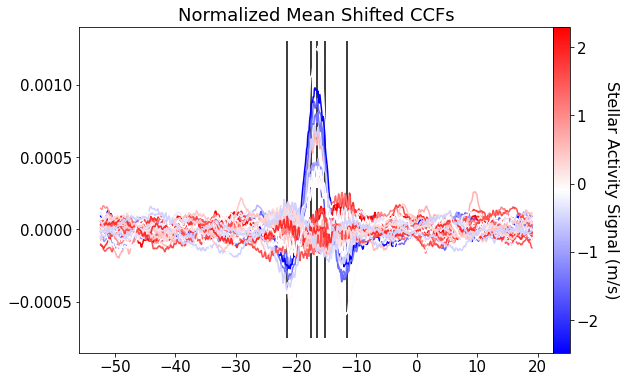

In [13]:
if star_name == '34411':
    ccf_indexes = [334, 356, 394, 409, 433]
elif star_name == '101501':
    ccf_indexes =  [334, 384, 399, 433]
elif star_name == '26965':
    ccf_indexes = [301, 339, 349, 359, 392]
elif star_name == '10700':
    ccf_indexes = [308, 349, 359, 372, 408]
else:
    print("ERROR: STAR NAME DOES NOT MATCH. PLEASE CHECK CELL 1.")

#ccf_indexes = [301, 339, 349, 359, 392]#[301, 339, 349, 359, 392] #[301, 339, 359, 392]#[301, 334, 344, 354, 392]
#ccf_indexes =  [start_index, start_index+sigma_og, start_index+2*sigma_og, start_index+3*sigma_og]#[290, 340, 355, 389]#[start_index, start_index+sigma_og, start_index+2*sigma_og, start_index+3*sigma_og]#[352, 305, 325, 367, 406]
#ccf_indexes = np.array(ccf_indexes) +4
# HD 34411: [334, 356, 394, 409, 433]
# HD 10150:  [334, 384, 399, 433]
# HD 26965: [301, 339, 349, 359, 392]
# HD 10700: [308, 349, 359, 372, 408]
a_coeff, y_preds, CCF_matrix, raw_rms, ccf_corr_rms = Weighted_LS_fit(ccf_indexes, ccf_list_np, 
                                                     ccf_list_np_transpose,rv_np, s_rv_np)
print(ccf_corr_rms)


residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "Normalized Mean Shifted CCFs")
plt.vlines(wls[0][ccf_indexes], ymin=-0.00075, ymax=0.0013, color="k")
ccf_indexes

50
50


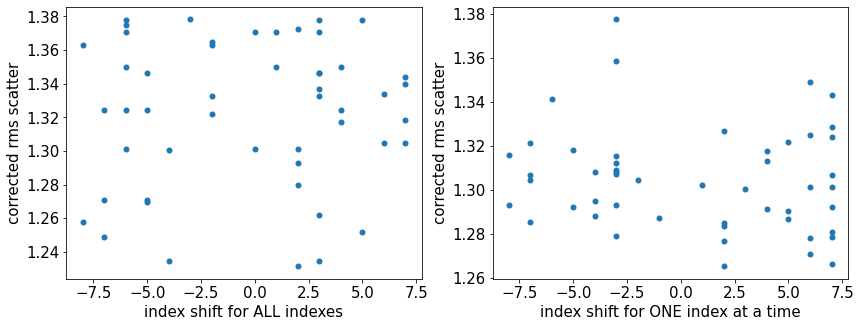

In [404]:
# Quick overfitting check

num_runs= 50
overfitting_checks(num_runs, ccf_indexes, ccf_list_np, ccf_list_np_transpose, rv_np, s_rv_np)

1.257582547018934

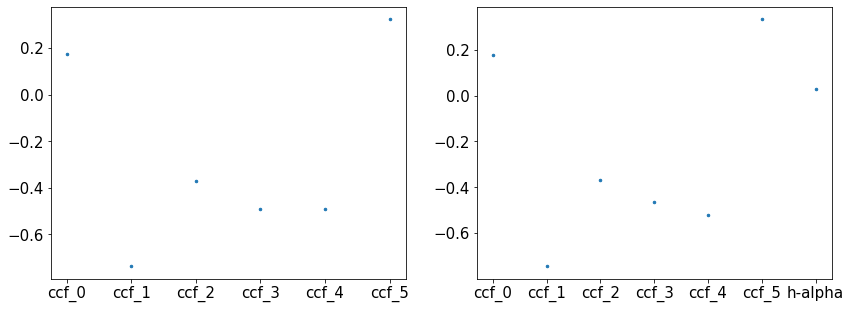

In [405]:
# run the LS fits

#first run the fit WITHOUT h-alpha
a_coeff, y_preds, CCF_matrix, raw_rms, ccf_corr_rms = Weighted_LS_fit(ccf_indexes, ccf_list_np, 
                                                     ccf_list_np_transpose,rv_np, s_rv_np)

# Now, run the weighted LS fit WITH h-alpha
a_coeff_hsb, y_preds_hsb, CCF_matrix_hsb, raw_rms_hsb, ccf_corr_rms_hsb = Weighted_LS_fit_with_h_alpha(ccf_indexes, 
                                                                          ccf_list_np, ccf_list_np_transpose_extra_info,
                                                                          rv_np, s_rv_np)


coeff_names = []
for i in np.arange(0, len(a_coeff)):
    coeff_names.append("ccf_"+str(i))
    
coeff_names_hsb = coeff_names.copy()
coeff_names_hsb.append("h-alpha")

fig, ax = plt.subplots(1,2, figsize=(14, 5))
ax[0].plot(coeff_names, a_coeff, ".")
ax[1].plot(coeff_names_hsb, a_coeff_hsb, ".")
ccf_corr_rms

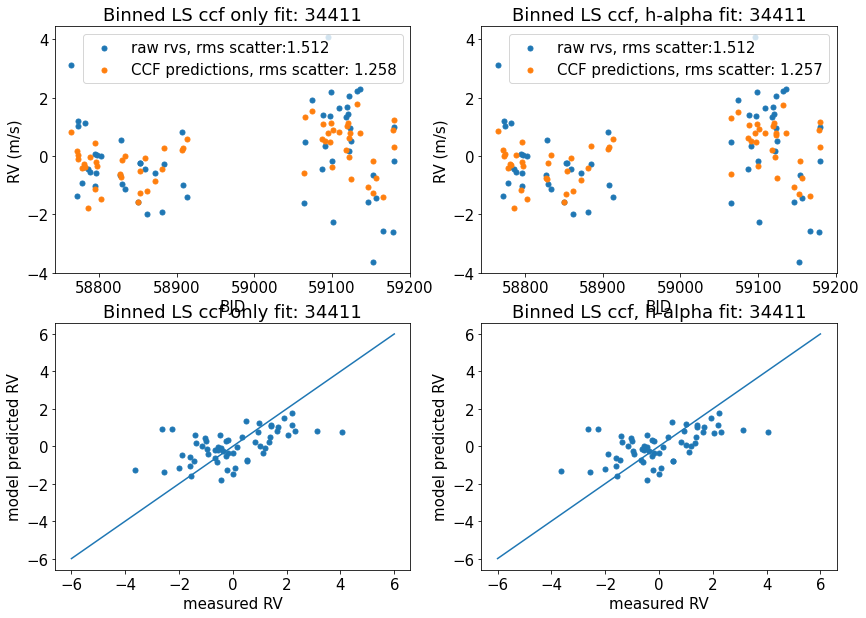

In [406]:
# plot the results from using only the ccf versus using the ccf+s-index+h-alpha 
results_compare_ccf_plot(df_sorted["BJD"], y, y_preds, raw_rms, ccf_corr_rms, 
                         y_preds_hsb, ccf_corr_rms_hsb, star_name)

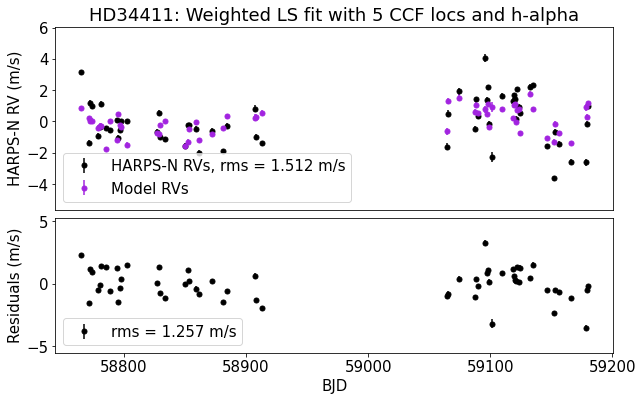

In [407]:
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(nrows=7, ncols=1)

# Column 1
ax0 = fig.add_subplot(gs[0:4, 0])
ax0.errorbar(time_np+np.min(df_sorted["BJD"]), y, yerr = s_rv_np, fmt = 'o', color='k', label="HARPS-N RVs, rms = "+str(round(raw_rms,3))+" m/s")
ax0.errorbar(time_np+np.min(df_sorted["BJD"]), y_preds_hsb, yerr = s_rv_np, fmt = 'o', color='#a224e0',label="Model RVs")
ax0.set_ylabel("HARPS-N RV (m/s)")#, size =14)
ax0.get_xaxis().set_visible(False)
ax0.set_ylim(np.min(y)-2,np.max(y)+2)
ax0.set_title("HD"+star_name+": Weighted LS fit with "+str(len(ccf_indexes))+" CCF locs and h-alpha")#, size =14)
ax0.legend(loc="lower left", fontsize=15)

ax1 = fig.add_subplot(gs[4:, 0])
ax1.errorbar(time_np+np.min(df_sorted["BJD"]), y-y_preds_hsb, yerr = s_rv_np, fmt = 'o', color='k',label="rms = "+str(round(ccf_corr_rms_hsb, 3))+" m/s")
ax1.set_ylabel("Residuals (m/s)")
ax1.set_xlabel("BJD")#, size =14)
ax1.set_ylim(np.min(y-y_preds_hsb)-2,np.max(y-y_preds_hsb)+2)
ax1.legend(loc="lower left",fontsize=15)


In [408]:
# create pandas dataframes
# write ccf ONLY coeff solution to csv (which will be used for the unbinned analysis)
df_coeff = pd.DataFrame(list(zip([ccf_indexes], [a_coeff], [star_name], [raw_rms], [ccf_corr_rms])),
                        columns=["ccf_indexes","a_coeff", "star name", "raw_rms", "ccf_corr_rms"])

# Make directory if it does not exist
if not os.path.exists('HD'+star_name+'/'+'binned_coeffs'):
    os.makedirs('HD'+star_name+'/'+'binned_coeffs')

# write results to a file 
df_coeff.to_csv('HD'+star_name+'/'+'binned_coeffs/coeff'+star_name+"_"+file_end+'June11.csv', index=False)

#-----------------------------------------------------------------------------

# write ccf, s-index, h-alpha solution to csv (which will be used for the unbinned analysis)
df_coeff_hsb = pd.DataFrame(list(zip([ccf_indexes], [a_coeff_hsb], [star_name], [raw_rms], [ccf_corr_rms_hsb])),
                        columns=["ccf_indexes","a_coeff", "star name", "raw_rms", "ccf_corr_rms"])

# Make directory if it does not exist
if not os.path.exists('HD'+star_name+'/'+'binned_coeffs'):
    os.makedirs('HD'+star_name+'/'+'binned_coeffs')

# write results to a file 
df_coeff.to_csv('HD'+star_name+'/'+'binned_coeffs/coeff'+star_name+"_"+file_end+'s-index_h-alpha_June11.csv', index=False)

In [409]:
# create dataframe to write ccf only results to a csv
nan_array = np.empty((1,len(df_sorted["BJD"])))
nan_array[:] = np.NaN

df_results = pd.DataFrame(list(zip(df_sorted["BJD"], 
                                   y-y_preds,nan_array[0], 
                                   y_preds, nan_array[0])),
                        columns=["Time [MJD]",
                                 "RV_C [m/s]","e_RV_C [m/s]",
                                 "RV_A [m/s]","e_RV_A [m/s]"])

# Make directory if it does not exist
if not os.path.exists('HD'+star_name+'/'+'ML_EPRVs_results/binned/'):
    os.makedirs('HD'+star_name+'/'+'ML_EPRVs_results/binned/')

if file_end == 'prov_rvs':
    full_ending = file_end+'_cbc_rvs'
else:
    full_ending = file_end+'_gauss'
    
# write results to a file 
df_results.to_csv('HD'+star_name+'/'+'ML_EPRVs_results/binned/binned_'+star_name+"_ML_EPRVs_CCFLinearRegression_"+full_ending+'.csv', index=False)

#-----------------------------------------------------------------------------

# create dataframe to write ccf, s-index, h-alpha results to a csv
df_results_hsb = pd.DataFrame(list(zip(df_sorted["BJD"], 
                                   y-y_preds_hsb,nan_array[0], 
                                   y_preds_hsb, nan_array[0])),
                        columns=["Time [MJD]",
                                 "RV_C [m/s]","e_RV_C [m/s]",
                                 "RV_A [m/s]","e_RV_A [m/s]"])

# Make directory if it does not exist
if not os.path.exists('HD'+star_name+'/'+'ML_EPRVs_results/binned/'):
    os.makedirs('HD'+star_name+'/'+'ML_EPRVs_results/binned/')

if file_end == 'prov_rvs':
    full_ending = file_end+'_cbc_rvs'
else:
    full_ending = file_end+'_gauss'
    
# write results to a file 
df_results_hsb.to_csv('HD'+star_name+'/'+'ML_EPRVs_results/binned/binned_'+star_name+"_ML_EPRVs_CCF_h-alpha_LinearRegression_"+full_ending+'.csv', index=False)

In [411]:
# Check file contents
pd_read= pd.read_csv('HD'+star_name+'/'+'ML_EPRVs_results/binned/binned_'+star_name+"_ML_EPRVs_CCF_h-alpha_LinearRegression_"+full_ending+'.csv') 
pd_read[0:10]

,Time [MJD],RV_C [m/s],e_RV_C [m/s],RV_A [m/s],e_RV_A [m/s]
0,58764.472656,2.281565,NaN,0.848329,NaN
1,58771.410156,-1.567461,NaN,0.203641,NaN
2,58772.480469,1.187714,NaN,0.004313,NaN
3,58773.460938,0.954233,NaN,0.054688,NaN
4,58778.429688,-0.488019,NaN,-0.425667,NaN
5,58780.394531,-0.114322,NaN,-0.265306,NaN
6,58781.449219,1.428965,NaN,-0.305602,NaN
7,58785.433594,1.340732,NaN,-1.781396,NaN
8,58788.464844,-0.583123,NaN,0.020390,NaN
9,58794.421875,1.237703,NaN,-1.174826,NaN


## Stop here. You are done.

## Code to find the planet in HD 26965

2.3840345364227007

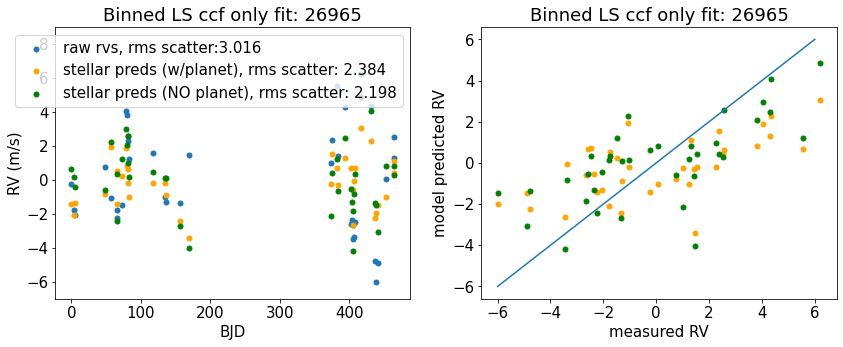

In [274]:
orbel = [42.378, -52828.72828125, 0.04, 2.6, 1.0]

# Now, run the weighted LS fit WITH h-alpha AND Planet Signal
a_coeff_h_pl, y_preds_h_pl, CCF_matrix_h_pl, raw_rms_h_pl, ccf_corr_rms_h_pl = Weighted_LS_fit_with_h_alpha_AND_planet(ccf_indexes, 
                                                                          ccf_list_np, ccf_list_np_transpose_extra_info,
                                                                          rv_np, s_rv_np, time_np, orbel)

stellar_preds = CCF_matrix_h_pl[:,1:].dot(a_coeff_h_pl[1:])
corrected_RVs = y - stellar_preds
uncorrected_RVs = y


fig, ax = plt.subplots(1,2, figsize=(14, 5))
#first plot the ccf-only results
ax[0].scatter(time_np,
                  y, label="raw rvs, rms scatter:"+str(round(raw_rms,3)))
ax[0].scatter(time_np,
                  stellar_preds, label="stellar preds (w/planet), rms scatter: "+str(round(np.std(corrected_RVs),3)), color='orange')
ax[0].scatter(time_np,
                  y_preds_hsb, label="stellar preds (NO planet), rms scatter: "+str(round(np.std(y-y_preds_hsb),3)), color='green')
ax[0].set_ylabel("RV (m/s)")
ax[0].set_xlabel("BJD")
ax[0].set_title("Binned LS ccf only fit: "+star_name)
ax[0].set_ylim(-7, 9)
ax[0].legend()

ax[1].scatter(y, stellar_preds, color='orange')
ax[1].scatter(y, y_preds_hsb, color='green')
ax[1].plot([-6,6],[-6,6])
ax[1].set_xlabel("measured RV")
ax[1].set_ylabel("model predicted RV")
ax[1].set_title("Binned LS ccf only fit: "+star_name)
    
a_coeff_h_pl[0]
np.std(corrected_RVs)

In [275]:
# Write this solution to a csv file (WITHOUT subtracting the planet signal)

nan_array = np.empty((1,len(df_sorted["BJD"])))
nan_array[:] = np.NaN

df_results = pd.DataFrame(list(zip(df_sorted["BJD"], 
                                   y-stellar_preds,nan_array[0], 
                                   stellar_preds, nan_array[0])),
                        columns=["Time [MJD]",
                                 "RV_C [m/s]","e_RV_C [m/s]",
                                 "RV_A [m/s]","e_RV_A [m/s]"])

# Make directory if it does not exist
if not os.path.exists('HD'+star_name+'/'+'ML_EPRVs_results/binned/'):
    os.makedirs('HD'+star_name+'/'+'ML_EPRVs_results/binned/')

if file_end == 'prov_rvs':
    full_ending = file_end+'_cbc_rvs'
else:
    full_ending = file_end+'_gauss'
    
# write results to a file 
df_results.to_csv('HD'+star_name+'/'+'ML_EPRVs_results/binned/binned_'+star_name+'_ML_EPRVs_CCF_h-alpha_keplerian_LinearRegression_'+full_ending+'.csv', index=False)

In [176]:
# phasefold the data
phase = np.array(time_np)%period  
binned_RVs = [] 
binned_phases = []
binned_uncertainties = []
binned_uncorr_RVs = []

for i in np.linspace(-1, 40, 7): #range(0, 20):
    index= np.where(np.abs(phase-i+0.5) < 7)
    #print(phase-i)
    print(index)
    weighted_avg_rv = np.sum(corrected_RVs[index]/s_rv_np[index]**2)/np.sum(1/s_rv_np[index]**2)
    weighted_avg_uncorr_rv = np.sum(uncorrected_RVs[index]/s_rv_np[index]**2)/np.sum(1/s_rv_np[index]**2)
    weighted_avg_phases = np.sum(phase[index]/s_rv_np[index]**2)/np.sum(1/s_rv_np[index]**2)
    weighted_avg_uncertainty= np.sqrt(1.0/np.sum(1.0/uncorrected_RVs[index]**2))
    binned_RVs.append(weighted_avg_rv)
    binned_uncorr_RVs.append(weighted_avg_uncorr_rv)
    binned_phases.append(weighted_avg_phases)
    binned_uncertainties.append(weighted_avg_uncertainty)
    
    
ti = np.linspace(np.min(df_sorted["BJD"])-5, np.max(df_sorted["BJD"])+5, 100)
e = 0.04
om = 2.6 #+180
K = 1 #1.81
T_c = 5886.76 -np.min(df_sorted["BJD"])

orbel = [period, T_c, e, om, K]
model = a_coeff_h_pl[0]*radvel.kepler.rv_drive(ti , orbel, use_c_kepler_solver=True)

df_rv= pd.DataFrame(list(zip(ti%period,model)), 
               columns =['phases',"planet",]) 
df_rv_sorted = df_rv.sort_values(by=['phases'])
orbel

(array([ 0,  1,  2, 20, 21]),)
(array([ 0,  1,  2,  3, 14, 15, 20, 21, 30]),)
(array([ 3,  4, 14, 15, 22, 30, 31, 32, 33]),)
(array([ 4,  5,  6, 22, 23, 24, 25, 26, 27, 31, 32, 33]),)
(array([ 5,  6,  7, 16, 23, 24, 25, 26, 27, 28, 34]),)
(array([ 7,  8,  9, 10, 11, 13, 16, 18, 19, 28, 29, 34]),)
(array([ 8,  9, 10, 11, 12, 13, 17, 18, 19, 29, 35, 36]),)


[42.378, -52828.72828125, 0.04, 2.6, 1]

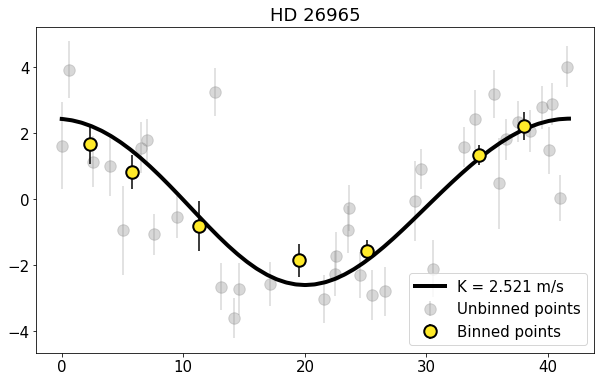

In [178]:
# Plot radvel model
fig, ax = plt.subplots(1,1, figsize=(10, 6))

ax.errorbar(phase, corrected_RVs, yerr = yerr*5, ecolor= 'grey', 
            color='grey',linestyle='none',marker='.', markersize=23, alpha=0.3, label="Unbinned points", zorder=1)
ax.errorbar(binned_phases, binned_RVs, yerr = binned_uncertainties, ecolor='k',
            color='#FFEA29',linestyle='none',marker='.', markersize=25, markeredgewidth=2, 
            markeredgecolor='k', label="Binned points", zorder=2)
plt.plot(df_rv_sorted["phases"], df_rv_sorted["planet"], color='k', linewidth=4, label="K = "+str(round(a_coeff_h_pl[0],3))+" m/s")
#plt.plot(ti%period, model,".", color='k', linewidth=4)
plt.title("HD 26965")
plt.legend()

In [190]:
# Run mcmc code to fit planet parameters


def log_likelihood(theta,t, x, y, e):
    a = theta
    jitterpar = a[0]
    orbel = [42.378, -52828.72828125, 0.04, 2.6, 1]
    kepler_model = radvel.kepler.rv_drive(t , orbel, use_c_kepler_solver=True)
    model = a[1]*kepler_model + x.dot(a[2:])
    sigma2 = e ** 2 + jitterpar**2
    loglikelihood = -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
    return loglikelihood


In [191]:
solnx = [3]#1.81]
for i in np.arange(0, len(a_coeff_h_pl)): # change back to 4 if you include linear and quadratic
    solnx = np.append(solnx, a_coeff_h_pl[i])

#solnx = a_coeff_h_pl
#solnx= np.append(solnx, [2])
#solnx.append(np.array([x for x in a_coeff_hsb]))
#solnx = np.array(solnx)
print(solnx)         
len(solnx)

[  3.           2.52094053   0.58279435  -4.85129945   2.86846301
 -14.59968001  11.46645501   3.0978751    0.46502038]


9

In [194]:
def log_prior(theta):
    a = theta
    if -1 < a[1] < 15:
        return 0.0
    return -np.inf

In [195]:
def log_probability(theta, t, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,t, x, y, yerr)

In [196]:
pos = solnx + 1e-6 * np.random.randn(60, len(solnx)) #ball size array for each parameter
pos[:,0] = solnx[0] + 1e-6 * np.random.randn(60)

nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time_np,
                                                                       CCF_matrix_hsb,
                                                                       rv_np, s_rv_np))
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:15<00:00, 326.27it/s]


State([[  1.60697055   2.23791813   0.22007708  -3.91223265   2.54778272
  -13.01376515  10.65008332   2.4516167    0.35576987]
 [  1.77192297   3.37436821   0.06094531  -4.64840575   4.85854744
  -17.43867707  11.99351152   2.02090087   0.29710926]
 [  1.74888763   2.63319872   1.16050231  -6.76487352   0.52074597
  -13.7205671   12.93539975   4.84184222   0.66562656]
 [  1.63540727   1.855659    -0.48982613  -2.38458309  10.83923774
  -22.46689458  11.93429353   1.67651017   0.63103569]
 [  1.74389951   2.23210143  -0.93879637  -1.3206058    9.03847439
  -17.11598568   7.91329963   0.44138857   0.44384315]
 [  1.67366515   1.722855     0.99902892  -5.70207258   0.88958248
  -12.86542701  12.22617502   3.43307262   0.08744092]
 [  1.68684299   2.48037025  -0.56218661  -4.85018944   9.12866747
  -24.25363412  14.64865043   2.15392268   0.47951855]
 [  1.6948819    2.60254857   0.19538703  -2.73193185   5.4626059
  -16.27633429  10.01992024   1.08097551   0.4949828 ]
 [  1.82099108   3.

Text(0.5, 0, 'step number')

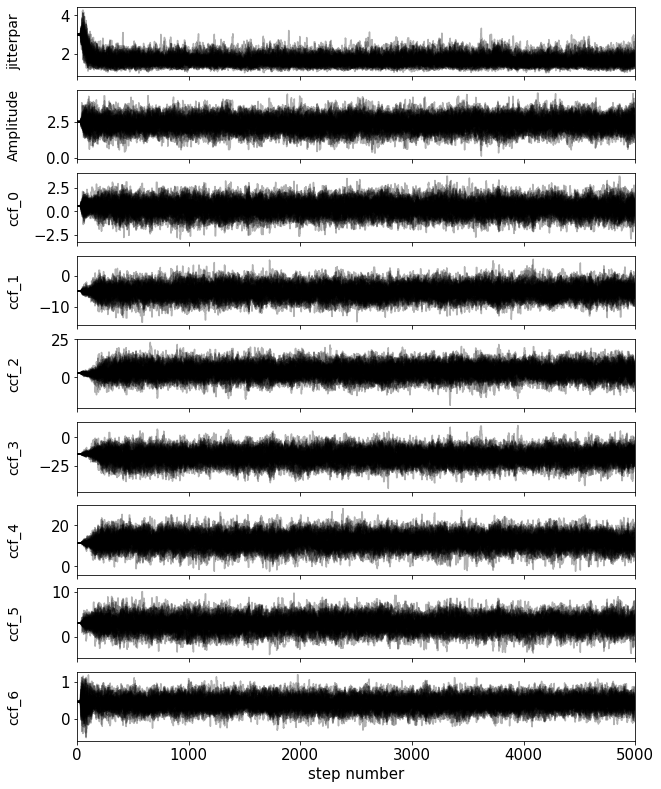

In [197]:
fig, axes = plt.subplots(len(solnx), figsize=(10, 1.5*len(solnx)), sharex=True)
samples = sampler.get_chain()
labels = ["jitterpar", "Amplitude"]
for i in np.arange(0, len(a_coeff_hsb)):
    labels.append("ccf_"+str(i))
labels.append("h-alpha")


for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], size=14)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [198]:
# discard first 1000 burn-in samples
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

flat_samples[0]

(15960, 9)


array([  1.30088632,   2.62532125,   0.34902872,  -4.69883983,
         0.37220084, -10.35599671,  10.22135453,   3.61735154,
         0.46295684])

In [199]:
# find the solution with the maximum likelihood

loglikelihood_list = []
for i in np.arange(0, len(flat_samples)):
    log_likelihood_iter =  log_likelihood(flat_samples[i]
                                     ,time_np, CCF_matrix_hsb, rv_np, rv_np)
    loglikelihood_list.append(log_likelihood_iter)
    #print("mcmc_log_likelihood: "+str(log_likelihood_iter))
    
most_like_index = np.where(loglikelihood_list == np.max(loglikelihood_list))[0][0]
loglikelihood_list[most_like_index]

most_likely_mcmc_coeffs = flat_samples[most_like_index]
most_likely_mcmc_coeffs

array([  1.03074255,   2.62315484,   0.06840461,  -3.4230898 ,
         4.2730182 , -14.0445805 ,   9.64187693,   2.09905096,
         0.32696452])

In [200]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    
print("LS coeffs: "+str(a_coeff_h_pl))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

LS coeffs: [  2.52094053   0.58279435  -4.85129945   2.86846301 -14.59968001
  11.46645501   3.0978751    0.46502038]


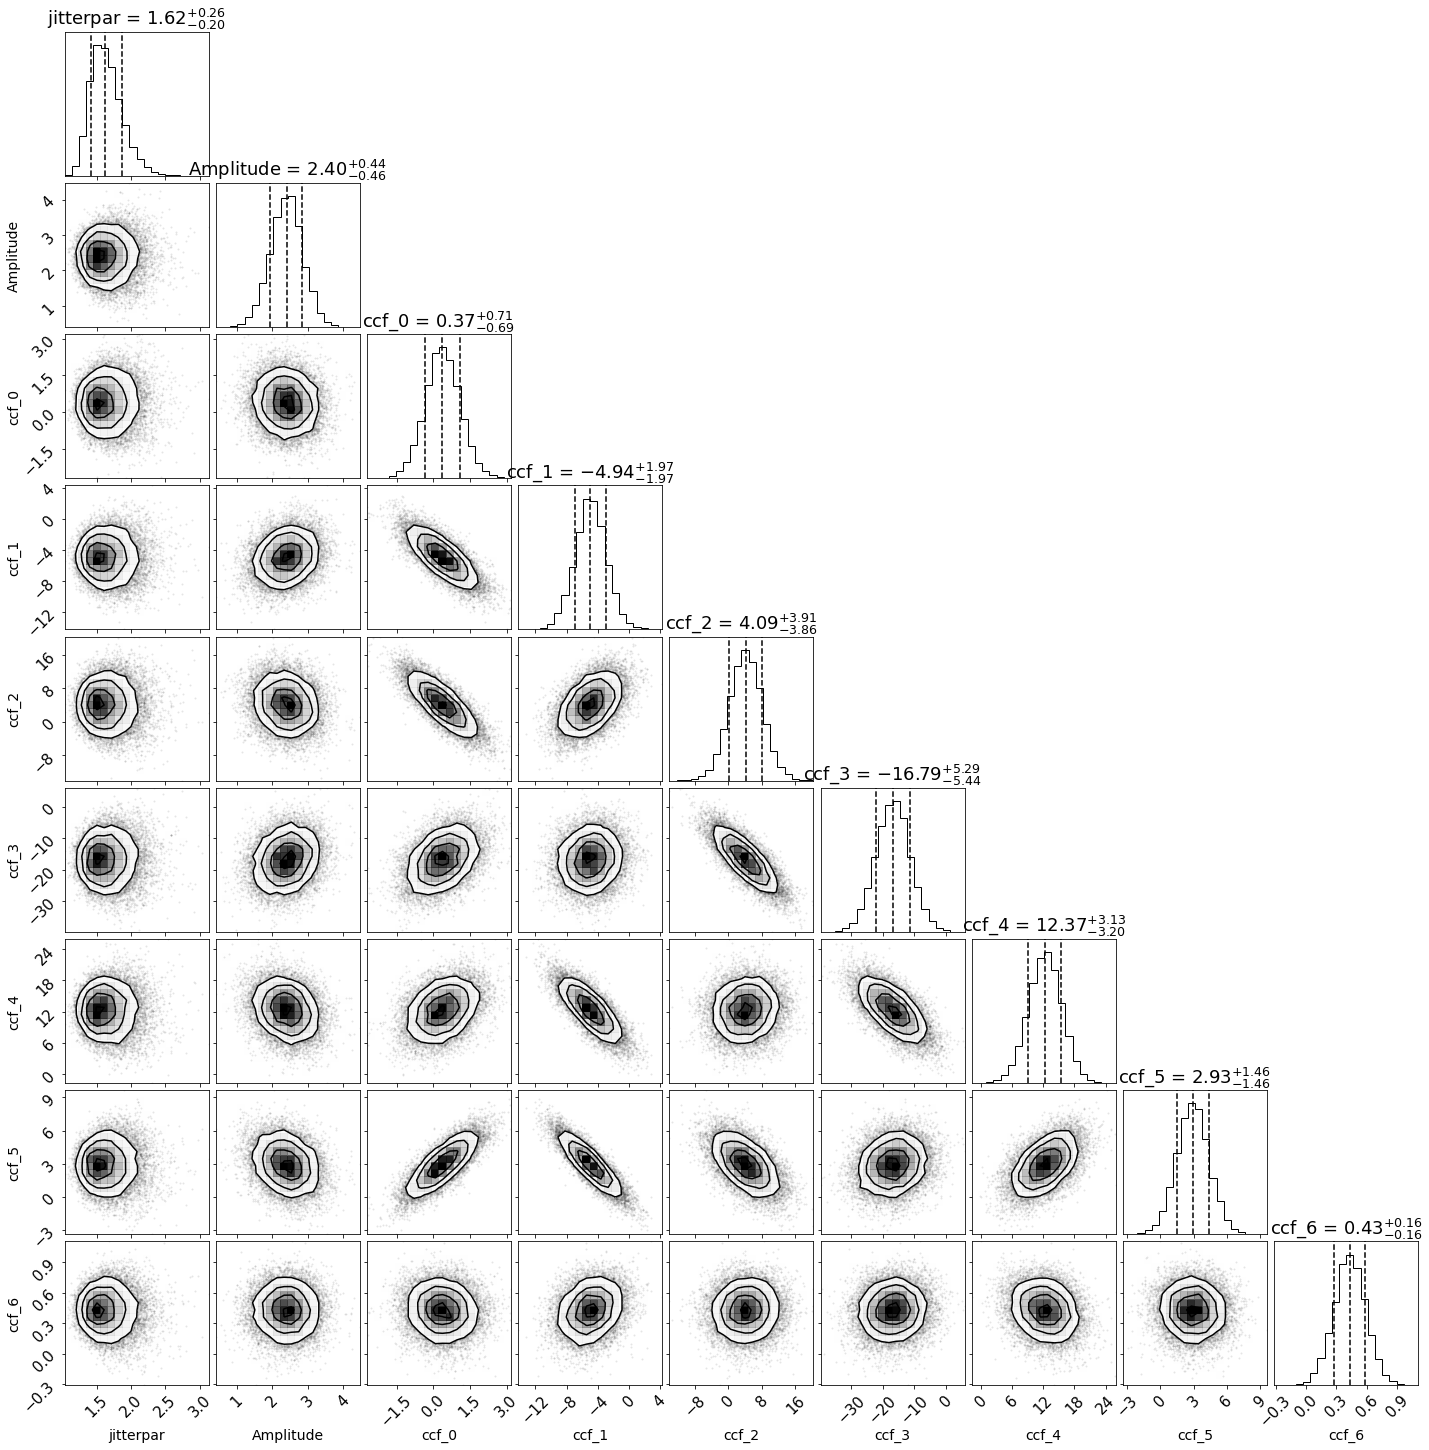

In [202]:
import corner
fig = corner.corner(
    flat_samples,
    labels=labels,
    quantiles=[0.159, 0.5, 0.841],
    show_titles=True,
    label_kwargs=dict(fontsize=14))

Text(0.5, 1.0, 'Binned mcmc fit, stellar + planet corr: 26965')

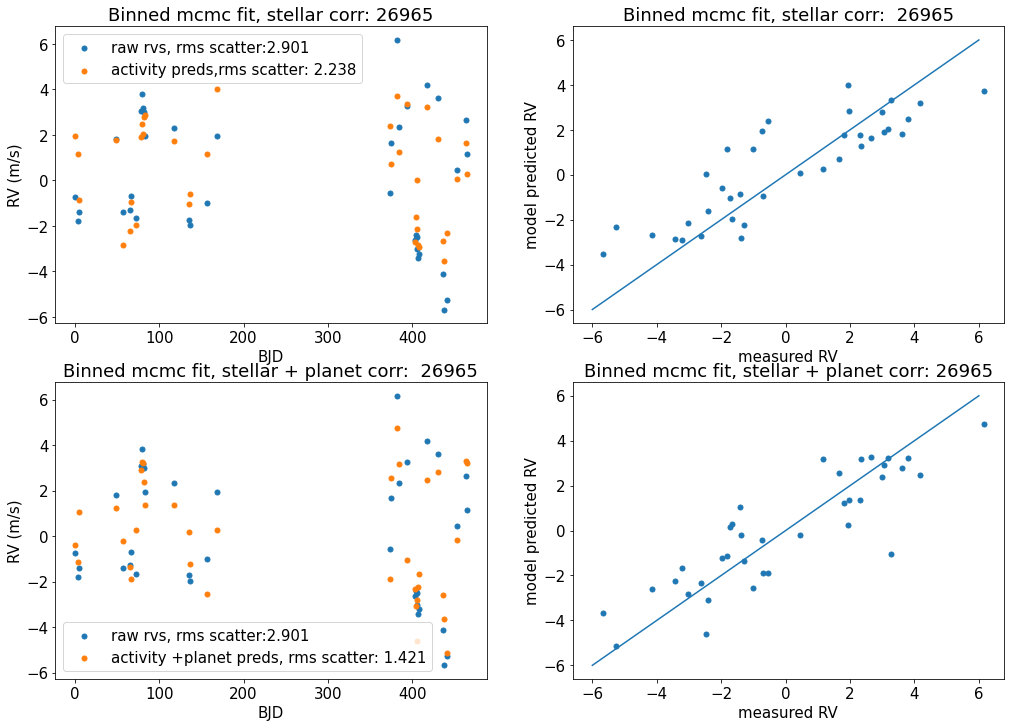

In [208]:
All_mcmc_coeffs = np.zeros(len(solnx))
for i in np.arange(0, len(solnx)):
    All_mcmc_coeffs[i]=  np.percentile(flat_samples[:, i], [50])[0]
    
# DELETE THIS LINE LATER
#All_mcmc_coeffs = most_likely_mcmc_coeffs
    
amp_75 =  np.percentile(flat_samples[:, 0], [75])[0]
amp_25 =  np.percentile(flat_samples[:, 0], [25])[0]
    
orbel = [42.378, -52828.72828125, 0.04, 2.6, All_mcmc_coeffs[1]]
kepler_model = radvel.kepler.rv_drive(time_np , orbel, use_c_kepler_solver=True)

mcmc_preds = kepler_model+ CCF_matrix_hsb.dot(All_mcmc_coeffs[2:])
mcmc_stellar_preds = CCF_matrix_hsb.dot(All_mcmc_coeffs[2:])
mcmc_corrected_RVs = y - CCF_matrix_hsb.dot(All_mcmc_coeffs[2:])
uncorrected_RVs = y

fig, ax = plt.subplots(2,2, figsize=(17, 12))
ax[0][0].scatter(time_np, y, label="raw rvs, rms scatter:"+str(round(np.std(y, ddof=1),3)))
ax[0][0].scatter(time_np, mcmc_corrected_RVs, 
                 label="activity preds,rms scatter: "+str(round(np.std(mcmc_corrected_RVs, ddof=1),3)))
ax[0][0].set_ylabel("RV (m/s)")
ax[0][0].set_xlabel("BJD")
ax[0][0].set_title("Binned mcmc fit, stellar corr: "+star_name)
ax[0][0].legend()

ax[0][1].scatter(y, mcmc_corrected_RVs)
ax[0][1].plot([-6,6],[-6,6])
ax[0][1].set_xlabel("measured RV")
ax[0][1].set_ylabel("model predicted RV")
ax[0][1].set_title("Binned mcmc fit, stellar corr:  "+star_name)


ax[1][0].scatter(time_np, y, label="raw rvs, rms scatter:"+str(round(np.std(y, ddof=1),3)))
ax[1][0].scatter(time_np, mcmc_preds, 
                 label="activity +planet preds, rms scatter: "+str(round(np.std(y-mcmc_preds, ddof=1),3)))
ax[1][0].set_ylabel("RV (m/s)")
ax[1][0].set_xlabel("BJD")
ax[1][0].set_title("Binned mcmc fit, stellar + planet corr:  "+star_name)
ax[1][0].legend()

ax[1][1].scatter(y, mcmc_preds)
ax[1][1].plot([-6,6],[-6,6])
ax[1][1].set_xlabel("measured RV")
ax[1][1].set_ylabel("model predicted RV")
ax[1][1].set_title("Binned mcmc fit, stellar + planet corr: "+star_name)

In [216]:
# phasefold the data

phase = np.array(time_np)%period  
binned_RVs = [] 
binned_phases = []
binned_uncertainties = []
binned_uncorr_RVs = []

for i in np.linspace(-1, 40, 7): #range(0, 20):
    index= np.where(np.abs(phase-i+0.5) < 7)
    #print(phase-i)
    print(index)
    weighted_avg_rv = np.sum(mcmc_corrected_RVs[index]/s_rv_np[index]**2)/np.sum(1/s_rv_np[index]**2)
    weighted_avg_uncorr_rv = np.sum(uncorrected_RVs[index]/s_rv_np[index]**2)/np.sum(1/s_rv_np[index]**2)
    weighted_avg_phases = np.sum(phase[index]/s_rv_np[index]**2)/np.sum(1/s_rv_np[index]**2)
    weighted_avg_uncertainty= np.sqrt(1.0/np.sum(1.0/uncorrected_RVs[index]**2))
    binned_RVs.append(weighted_avg_rv)
    binned_uncorr_RVs.append(weighted_avg_uncorr_rv)
    binned_phases.append(weighted_avg_phases)
    binned_uncertainties.append(weighted_avg_uncertainty)

    
orbel = [42.378, -52828.72828125, 0.04, 2.6, 1]
ti = np.linspace(np.min(time_np)-5, np.max(time_np)+5, 100)
kepler_model_ti = All_mcmc_coeffs[1]*radvel.kepler.rv_drive(ti, orbel, use_c_kepler_solver=True)
kepler_model_ti_25 = amp_25*radvel.kepler.rv_drive(ti, orbel, use_c_kepler_solver=True)
kepler_model_ti_75 = amp_75*radvel.kepler.rv_drive(ti, orbel75, use_c_kepler_solver=True)    

df_rv_mcmc= pd.DataFrame(list(zip(ti%period,kepler_model_ti, kepler_model_ti_25, kepler_model_ti_75)), 
               columns =['phases',"planet_50th","planet_25th", "planet_75th"]) 
df_rv_mcmc_sorted = df_rv_mcmc.sort_values(by=['phases'])

(array([ 0,  1,  2, 20, 21]),)
(array([ 0,  1,  2,  3, 14, 15, 20, 21, 30]),)
(array([ 3,  4, 14, 15, 22, 30, 31, 32, 33]),)
(array([ 4,  5,  6, 22, 23, 24, 25, 26, 27, 31, 32, 33]),)
(array([ 5,  6,  7, 16, 23, 24, 25, 26, 27, 28, 34]),)
(array([ 7,  8,  9, 10, 11, 13, 16, 18, 19, 28, 29, 34]),)
(array([ 8,  9, 10, 11, 12, 13, 17, 18, 19, 29, 35, 36]),)


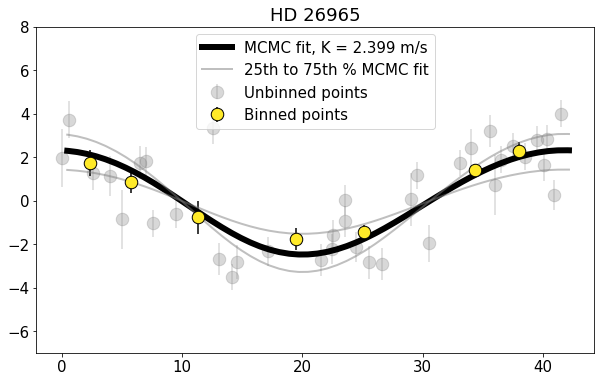

In [236]:
# Plot radvel mcmc model
fig, ax = plt.subplots(1,1, figsize=(10, 6))


ax.errorbar(phase, mcmc_corrected_RVs, yerr = yerr*5, ecolor= 'grey', 
            color='grey',linestyle='none',marker='.', markersize=25, alpha=0.3, label="Unbinned points", zorder=1)
ax.errorbar(binned_phases, binned_RVs, yerr = binned_uncertainties, ecolor='k',
            color='#FFEA29',linestyle='none',marker='.', markersize=25, markeredgewidth=1, 
            markeredgecolor='k', label="Binned points", zorder=2)
plt.plot(df_rv_mcmc_sorted["phases"], df_rv_mcmc_sorted["planet_50th"], color='k', linewidth=6, label="MCMC fit, K = "+str(round(All_mcmc_coeffs[1],3))+" m/s")
#plt.plot(ti%period, kepler_model_ti,".", color='k', linewidth=4, label="50th %, K = "+str(round(All_mcmc_coeffs[0],3))+" m/s")
plt.plot(df_rv_mcmc_sorted["phases"], df_rv_mcmc_sorted["planet_25th"], color='gray', alpha=0.5, linewidth=2, label="25th to 75th % MCMC fit")
plt.plot(df_rv_mcmc_sorted["phases"], df_rv_mcmc_sorted["planet_75th"], color='gray', alpha=0.5, linewidth=2)#, label="75th %, K = "+str(round(amp_75,3))+" m/s")
plt.ylim(-7, 8)


plt.title("HD 26965")
ax.legend(loc="upper center")

## Compare ccf results +s-index and h-alpha with including only the BIS, FWHM 

original: [306, 347, 357, 367, 406]
[1 1 4 1 2]
randomized: [307 348 361 368 408]
1.0496748502240199
0.6697139593870806


array([ 0.47639267,  1.58578211,  1.8003262 , -2.12305345, -0.77322246,
       -1.9980918 ,  1.6558271 , -3.10296168,  1.44911188])

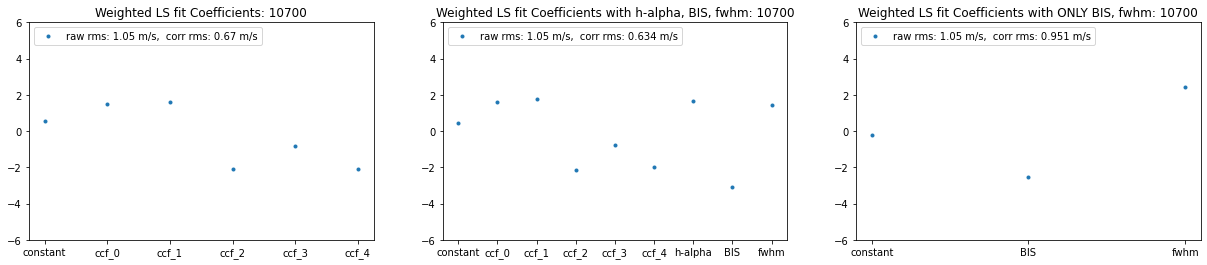

In [7]:
ccf_indexes =  [306, 347, 357, 367, 406]#[318, 335, 352, 369]#[352, 305, 325, 367, 406]
print("original: " +str(ccf_indexes))
random_noise = np.random.randint(1, 5, size= 5)
print(random_noise)
ccf_indexes = ccf_indexes+random_noise
print("randomized: " +str(ccf_indexes))

# HD 34411: [350, 388, 398, 408, 441]
# HD 10150: [330, 364, 376, 388, 398, 425]
# HD 26965: [301, 339, 349, 359, 392]
# HD 10700: [306, 347, 357, 367, 406]

#Weighted LS fit WITHOUT h-alpha, s-index, BIS
a_coeff, y_preds, CCF_matrix, raw_rms, ccf_corr_rms = Weighted_LS_fit(ccf_indexes, ccf_list_np, 
                                                     ccf_list_np_transpose,rv_np, s_rv_np)

#Weighted LS fit WITH h-alpha, s-index, BIS
a_coeff_hsb, y_preds_hsb, CCF_matrix_hsb, raw_rms_hsb, ccf_corr_rms_hsb = Weighted_LS_fit_with_s_index_h_alpha(ccf_indexes, 
                                                                          ccf_list_np, ccf_list_np_transpose,
                                                                          rv_np, s_rv_np)
#Weighted LS fit WITH ONLY fwhm, BIS
a_coeff_fwbis, y_preds_fwbis, CCF_matrix_fwbis, raw_rms_fwbis, ccf_corr_rms_fwbis = Weighted_LS_fit_fwhm_BIS(ccf_indexes, 
                                                                          ccf_list_np, ccf_list_np_transpose,
                                                                          rv_np, s_rv_np)



print(raw_rms)
print(ccf_corr_rms)


coeff_names = ["constant", "ccf_0", "ccf_1", "ccf_2", "ccf_3", "ccf_4"]
coeff_names_hsb = ["constant", "ccf_0", "ccf_1", "ccf_2", "ccf_3", "ccf_4","h-alpha","BIS", "fwhm"]
coeff_names_fwbis = ["constant", "BIS", "fwhm"]

fig, ax = plt.subplots(1,3, figsize=(21, 4))
ax[0].plot(coeff_names, a_coeff, ".", label="raw rms: "+str(round(raw_rms, 3))+" m/s,  corr rms: "+str(round(ccf_corr_rms, 3))+" m/s" )
ax[0].set_title("Weighted LS fit Coefficients: "+str(star_name))
ax[0].legend(loc="upper left")
ax[0].set_ylim(-6,6)

ax[1].plot(coeff_names_hsb, a_coeff_hsb, ".", label="raw rms: "+str(round(raw_rms_hsb, 3))+" m/s,  corr rms: "+str(round(ccf_corr_rms_hsb, 3))+" m/s" )
ax[1].set_title("Weighted LS fit Coefficients with h-alpha, BIS, fwhm: "+str(star_name))
ax[1].legend(loc="upper left")
ax[1].set_ylim(-6,6)

ax[2].plot(coeff_names_fwbis, a_coeff_fwbis, ".", label="raw rms: "+str(round(raw_rms_fwbis, 3))+" m/s,  corr rms: "+str(round(ccf_corr_rms_fwbis, 3))+" m/s" )
ax[2].set_title("Weighted LS fit Coefficients with ONLY BIS, fwhm: "+str(star_name))
ax[2].legend(loc="upper left")
ax[2].set_ylim(-6,6)

a_coeff_hsb

## Evaluate the BIC to decide on the number of CCF Indexes

In [339]:
night_e_np = np.array(list([0.40]*len(rv_np)))
night_e_np

array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])

In [340]:
a_coeff, y_preds, x, og_rms, new_rms = Weighted_LS_fit(ccf_indexes,
                                                           ccf_list_np,
                                                           ccf_list_np_transpose,
                                                           rv_np, night_e_np)
#night_e_np = np.array(list([0.40]*len(rv_np)))
#night_e_np

In [338]:
#indexes_list = []

0.0 1.0
4
0.6032553575826224
[313, 350, 360, 407]
[318 355 365 412]


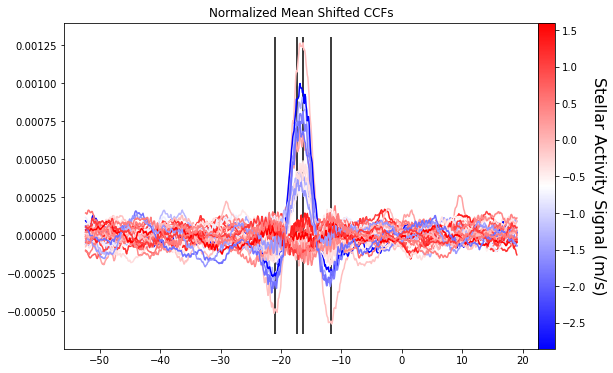

In [327]:
# choose indexes to append to the indexes_list
ccf_indexes = indexes_list[0].copy()
rand_index = np.random.randint(0, len(ccf_indexes))
ccf_indexes[rand_index] = ccf_indexes[rand_index]+np.random.randint(3,10)
#+np.random.randint(-10,10,size=1)#[int(k) for k in np.linspace(300, 420, 15)]#np.array([310, 350, 360, 369, 407])#np.array([310, 350, 360, 369, 407])+np.random.randint(1,10,size=1)

residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "Normalized Mean Shifted CCFs")
plt.vlines(wls[0][ccf_indexes], ymin=-0.00065, ymax=0.0013, color="k")

a_coeff, y_preds, x, og_rms, new_rms = Weighted_LS_fit(ccf_indexes,
                                                           ccf_list_np,
                                                           ccf_list_np_transpose,
                                                           rv_np, night_e_np)
print(len(ccf_indexes))
print(new_rms)
print(ccf_indexes)
print(ccf_indexes+np.random.randint(3,10,size=1))

In [217]:
for i in range(0,12):
    ccf_indexes =  indexes_list[i].copy() + np.random.randint(3,10,size=1)
    #rand_index = np.random.randint(0, len(ccf_indexes))
    #ccf_indexes[rand_index] = ccf_indexes[rand_index]+np.random.randint(3,10)

    # append to indexes list
    #indexes_list.append(ccf_indexes.tolist())
print(len(indexes_list))
print(len(indexes_list)/12)
indexes_list

120
10.0


[[310, 350, 360, 407],
 [310, 350, 360, 369, 407],
 [310, 330, 350, 360, 369, 407],
 [310, 330, 350, 360, 369, 385, 407],
 [300, 310, 330, 350, 360, 369, 385, 407],
 [300, 310, 330, 350, 360, 369, 385, 407, 420],
 [284, 300, 310, 330, 350, 360, 369, 385, 407, 420],
 [284, 300, 310, 330, 350, 360, 369, 385, 407, 420, 435],
 [270, 284, 300, 310, 330, 350, 360, 369, 385, 407, 420, 435],
 [270, 284, 300, 310, 330, 350, 360, 369, 385, 407, 420, 435, 454],
 [270, 284, 300, 310, 330, 340, 350, 360, 369, 385, 407, 420, 435, 454],
 [270, 284, 300, 310, 330, 340, 350, 360, 369, 385, 394, 407, 420, 435, 454],
 [0, 238, 476, 715],
 [0, 178, 357, 536, 715],
 [0, 143, 286, 429, 572, 715],
 [0, 119, 238, 357, 476, 595, 715],
 [0, 102, 204, 306, 408, 510, 612, 715],
 [0, 89, 178, 268, 357, 446, 536, 625, 715],
 [0, 79, 158, 238, 317, 397, 476, 556, 635, 715],
 [0, 71, 143, 214, 286, 357, 429, 500, 572, 643, 715],
 [0, 65, 130, 195, 260, 325, 390, 455, 520, 585, 650, 715],
 [0, 59, 119, 178, 238, 297, 

In [341]:
manual_list = [[310, 350, 360, 407],
 [310, 350, 360, 369, 407],
 [310, 330, 350, 360, 369, 407],
 [310, 330, 350, 360, 369, 385, 407],
 [300, 310, 330, 350, 360, 369, 385, 407],
 [300, 310, 330, 350, 360, 369, 385, 407, 420],
 [284, 300, 310, 330, 350, 360, 369, 385, 407, 420],
 [284, 300, 310, 330, 350, 360, 369, 385, 407, 420, 435],
 [270, 284, 300, 310, 330, 350, 360, 369, 385, 407, 420, 435],
 [270, 284, 300, 310, 330, 350, 360, 369, 385, 407, 420, 435, 454],
 [270, 284, 300, 310, 330, 340, 350, 360, 369, 385, 407, 420, 435, 454],
 [270, 284, 300, 310, 330, 340, 350, 360, 369, 385, 394, 407, 420, 435, 454]]

indexes_list = [[310, 350, 360, 407],
 [310, 350, 360, 369, 407],
 [310, 330, 350, 360, 369, 407],
 [310, 330, 350, 360, 369, 385, 407],
 [300, 310, 330, 350, 360, 369, 385, 407],
 [300, 310, 330, 350, 360, 369, 385, 407, 420],
 [284, 300, 310, 330, 350, 360, 369, 385, 407, 420],
 [284, 300, 310, 330, 350, 360, 369, 385, 407, 420, 435],
 [270, 284, 300, 310, 330, 350, 360, 369, 385, 407, 420, 435],
 [270, 284, 300, 310, 330, 350, 360, 369, 385, 407, 420, 435, 454],
 [270, 284, 300, 310, 330, 340, 350, 360, 369, 385, 407, 420, 435, 454],
 [270, 284, 300, 310, 330, 340, 350, 360, 369, 385, 394, 407, 420, 435, 454],
 [0, 238, 476, 714],
 [0, 178, 357, 536, 714],
 [0, 143, 286, 429, 572, 714],
 [0, 119, 238, 357, 476, 595, 714],
 [0, 102, 204, 306, 408, 510, 612, 714],
 [0, 89, 178, 268, 357, 446, 536, 625, 714],
 [0, 79, 158, 238, 317, 397, 476, 556, 635, 714],
 [0, 71, 143, 214, 286, 357, 429, 500, 572, 643, 714],
 [0, 65, 130, 195, 260, 325, 390, 455, 520, 585, 650, 714],
 [0, 59, 119, 178, 238, 297, 357, 417, 476, 536, 595, 655, 714],
 [0, 55, 110, 165, 220, 275, 330, 385, 440, 495, 550, 605, 660, 714],
 [0, 51, 102, 153, 204, 255, 306, 357, 408, 459, 510, 561, 612, 663, 714],
 [300, 340, 380, 420],
 [300, 330, 360, 390, 420],
 [300, 324, 348, 372, 396, 420],
 [300, 320, 340, 360, 380, 400, 420],
 [300, 317, 334, 351, 368, 385, 402, 420],
 [300, 315, 330, 345, 360, 375, 390, 405, 420],
 [300, 313, 326, 340, 353, 366, 380, 393, 406, 420],
 [300, 312, 324, 336, 348, 360, 372, 384, 396, 408, 420],
 [300, 310, 321, 332, 343, 354, 365, 376, 387, 398, 409, 420],
 [300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420],
 [300, 309, 318, 327, 336, 346, 355, 364, 373, 383, 392, 401, 410, 420],
 [300, 308, 317, 325, 334, 342, 351, 360, 368, 377, 385, 394, 402, 411, 420],
 [310, 343, 376, 410],
 [310, 335, 360, 385, 410],
 [310, 330, 350, 370, 390, 410],
 [310, 326, 343, 360, 376, 393, 410],
 [310, 324, 338, 352, 367, 381, 395, 410],
 [310, 322, 335, 347, 360, 372, 385, 397, 410],
 [310, 321, 332, 343, 354, 365, 376, 387, 398, 410],
 [310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410],
 [310, 319, 328, 337, 346, 355, 364, 373, 382, 391, 400, 410],
 [310, 318, 326, 335, 343, 351, 360, 368, 376, 385, 393, 401, 410],
 [310, 317, 325, 333, 340, 348, 356, 363, 371, 379, 386, 394, 402, 410],
 [310, 317, 324, 331, 338, 345, 352, 360, 367, 374, 381, 388, 395, 402, 410],
 [315, 345, 375, 405],
 [315, 337, 360, 382, 405],
 [315, 333, 351, 369, 387, 405],
 [315, 330, 345, 360, 375, 390, 405],
 [315, 327, 340, 353, 366, 379, 392, 405],
 [315, 326, 337, 348, 360, 371, 382, 393, 405],
 [315, 325, 335, 345, 355, 365, 375, 385, 395, 405],
 [315, 324, 333, 342, 351, 360, 369, 378, 387, 396, 405],
 [315, 323, 331, 339, 347, 355, 364, 372, 380, 388, 396, 405],
 [315, 322, 330, 337, 345, 352, 360, 367, 375, 382, 390, 397, 405],
 [315, 321, 328, 335, 342, 349, 356, 363, 370, 377, 384, 391, 398, 405],
 [315, 321, 327, 334, 340, 347, 353, 360, 366, 372, 379, 385, 392, 398, 405],
 [317, 350, 360, 407],
 [318, 350, 360, 369, 407],
 [319, 330, 350, 360, 369, 407],
 [310, 334, 350, 360, 369, 385, 407],
 [300, 310, 334, 350, 360, 369, 385, 407],
 [300, 310, 330, 350, 368, 369, 385, 407, 420],
 [284, 300, 310, 330, 350, 360, 369, 385, 413, 420],
 [284, 300, 310, 330, 350, 360, 369, 390, 407, 420, 435],
 [270, 284, 300, 310, 330, 350, 360, 369, 394, 407, 420, 435],
 [270, 291, 300, 310, 330, 350, 360, 369, 385, 407, 420, 435, 454],
 [277, 284, 300, 310, 330, 340, 350, 360, 369, 385, 407, 420, 435, 454],
 [270, 284, 300, 310, 330, 340, 350, 360, 369, 385, 394, 407, 420, 435, 459],
 [319, 350, 360, 407],
 [310, 350, 364, 369, 407],
 [310, 336, 350, 360, 369, 407],
 [319, 330, 350, 360, 369, 385, 407],
 [308, 310, 330, 350, 360, 369, 385, 407],
 [300, 316, 330, 350, 360, 369, 385, 407, 420],
 [284, 300, 318, 330, 350, 360, 369, 385, 407, 420],
 [284, 300, 310, 330, 350, 360, 369, 385, 407, 428, 435],
 [270, 284, 300, 310, 336, 350, 360, 369, 385, 407, 420, 435],
 [270, 284, 300, 310, 330, 350, 360, 369, 385, 407, 428, 435, 454],
 [270, 284, 300, 310, 334, 340, 350, 360, 369, 385, 407, 420, 435, 454],
 [270, 284, 300, 310, 330, 340, 350, 360, 369, 385, 394, 407, 420, 444, 454],
 [317, 350, 360, 407],
 [310, 350, 360, 369, 411],
 [310, 330, 355, 360, 369, 407],
 [310, 330, 350, 360, 375, 385, 407],
 [300, 310, 330, 350, 364, 369, 385, 407],
 [300, 310, 330, 350, 360, 369, 385, 416, 420],
 [284, 300, 310, 330, 350, 360, 369, 393, 407, 420],
 [284, 300, 310, 330, 350, 363, 369, 385, 407, 420, 435],
 [273, 284, 300, 310, 330, 350, 360, 369, 385, 407, 420, 435],
 [270, 284, 300, 319, 330, 350, 360, 369, 385, 407, 420, 435, 454],
 [270, 284, 300, 310, 330, 348, 350, 360, 369, 385, 407, 420, 435, 454],
 [270, 284, 300, 310, 330, 340, 350, 360, 369, 389, 394, 407, 420, 435, 454],
 [318, 358, 368, 415],
 [319, 359, 369, 378, 416],
 [314, 334, 354, 364, 373, 411],
 [318, 338, 358, 368, 377, 393, 415],
 [304, 314, 334, 354, 364, 373, 389, 411],
 [304, 314, 334, 354, 364, 373, 389, 411, 424],
 [287, 303, 313, 333, 353, 363, 372, 388, 410, 423],
 [293, 309, 319, 339, 359, 369, 378, 394, 416, 429, 444],
 [276, 290, 306, 316, 336, 356, 366, 375, 391, 413, 426, 441],
 [279, 293, 309, 319, 339, 359, 369, 378, 394, 416, 429, 444, 463],
 [274, 288, 304, 314, 334, 344, 354, 364, 373, 389, 411, 424, 439, 458],
 [275, 289, 305, 315, 335, 345, 355, 365, 374, 390, 399, 412, 425, 440, 459],
 [316, 356, 366, 413],
 [315, 355, 365, 374, 412],
 [315, 335, 355, 365, 374, 412],
 [313, 333, 353, 363, 372, 388, 410],
 [306, 316, 336, 356, 366, 375, 391, 413],
 [307, 317, 337, 357, 367, 376, 392, 414, 427],
 [293, 309, 319, 339, 359, 369, 378, 394, 416, 429],
 [287, 303, 313, 333, 353, 363, 372, 388, 410, 423, 438],
 [275, 289, 305, 315, 335, 355, 365, 374, 390, 412, 425, 440],
 [276, 290, 306, 316, 336, 356, 366, 375, 391, 413, 426, 441, 460],
 [274, 288, 304, 314, 334, 344, 354, 364, 373, 389, 411, 424, 439, 458],
 [275, 289, 305, 315, 335, 345, 355, 365, 374, 390, 399, 412, 425, 440, 459]]
len(indexes_list)/12
 

10.0

In [342]:
indexes_list.sort(key=lambda x: len(x))

indexes_list

[[310, 350, 360, 407],
 [0, 238, 476, 714],
 [300, 340, 380, 420],
 [310, 343, 376, 410],
 [315, 345, 375, 405],
 [317, 350, 360, 407],
 [319, 350, 360, 407],
 [317, 350, 360, 407],
 [318, 358, 368, 415],
 [316, 356, 366, 413],
 [310, 350, 360, 369, 407],
 [0, 178, 357, 536, 714],
 [300, 330, 360, 390, 420],
 [310, 335, 360, 385, 410],
 [315, 337, 360, 382, 405],
 [318, 350, 360, 369, 407],
 [310, 350, 364, 369, 407],
 [310, 350, 360, 369, 411],
 [319, 359, 369, 378, 416],
 [315, 355, 365, 374, 412],
 [310, 330, 350, 360, 369, 407],
 [0, 143, 286, 429, 572, 714],
 [300, 324, 348, 372, 396, 420],
 [310, 330, 350, 370, 390, 410],
 [315, 333, 351, 369, 387, 405],
 [319, 330, 350, 360, 369, 407],
 [310, 336, 350, 360, 369, 407],
 [310, 330, 355, 360, 369, 407],
 [314, 334, 354, 364, 373, 411],
 [315, 335, 355, 365, 374, 412],
 [310, 330, 350, 360, 369, 385, 407],
 [0, 119, 238, 357, 476, 595, 714],
 [300, 320, 340, 360, 380, 400, 420],
 [310, 326, 343, 360, 376, 393, 410],
 [315, 330, 345,

In [343]:
BIC_value_list = []

for i in range(0, len(indexes_list)):
    ccf_indexes = indexes_list[i].copy()
    print(ccf_indexes)
    BIC_value = BIC(ccf_indexes, ccf_list_np, ccf_list_np_transpose, rv_np, night_e_np)
    BIC_value_list.append(BIC_value)


[310, 350, 360, 407]
[0, 238, 476, 714]
[300, 340, 380, 420]
[310, 343, 376, 410]
[315, 345, 375, 405]
[317, 350, 360, 407]
[319, 350, 360, 407]
[317, 350, 360, 407]
[318, 358, 368, 415]
[316, 356, 366, 413]
[310, 350, 360, 369, 407]
[0, 178, 357, 536, 714]
[300, 330, 360, 390, 420]
[310, 335, 360, 385, 410]
[315, 337, 360, 382, 405]
[318, 350, 360, 369, 407]
[310, 350, 364, 369, 407]
[310, 350, 360, 369, 411]
[319, 359, 369, 378, 416]
[315, 355, 365, 374, 412]
[310, 330, 350, 360, 369, 407]
[0, 143, 286, 429, 572, 714]
[300, 324, 348, 372, 396, 420]
[310, 330, 350, 370, 390, 410]
[315, 333, 351, 369, 387, 405]
[319, 330, 350, 360, 369, 407]
[310, 336, 350, 360, 369, 407]
[310, 330, 355, 360, 369, 407]
[314, 334, 354, 364, 373, 411]
[315, 335, 355, 365, 374, 412]
[310, 330, 350, 360, 369, 385, 407]
[0, 119, 238, 357, 476, 595, 714]
[300, 320, 340, 360, 380, 400, 420]
[310, 326, 343, 360, 376, 393, 410]
[315, 330, 345, 360, 375, 390, 405]
[310, 334, 350, 360, 369, 385, 407]
[319, 330, 3

In [347]:
np.mean(s_rv_np)

0.15064035206331242

In [344]:
indexes_list_lengths= [len(x) for x in indexes_list]

Text(0.5, 0, 'num of ccf indexes')

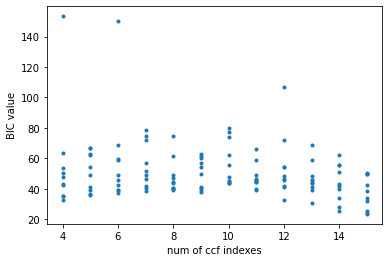

In [345]:
plt.plot(indexes_list_lengths, BIC_value_list, ".")
plt.ylabel("BIC value")
plt.xlabel("num of ccf indexes")

In [12]:
jitterpar = 0

In [13]:
def log_likelihood(theta, t, x, y, e):
    #amplitude, jitterpar, D, a0, a1, a2, a3, a4, a5, a6, a7 = theta
    D, a0, a1, a2, a3, a4  = theta
    #jitterpar, D, a0, a1, a2, a3, a4 = theta
    #model = amplitude * np.sin(2*np.pi*(t-T_c)/period + np.pi) + D + a0*x[:,0] + a1*x[:,1] + a2*x[:,2] + a3*x[:,3] + a4*x[:,4] +a5*x[:,5] + a6*x[:,6] + a7*x[:,7] #+ a8*x[:,8]+ a9*x[:,9] + a10*x[:,10] + a11*x[:,11] +a12*x[:,12]
    model = D + a0*x[:,0] + a1*x[:,1] + a2*x[:,2] + a3*x[:,3] + a4*x[:,4]# +a5*x[:,5] + a6*x[:,6] + a7*x[:,7] +a8*x[:,8]
    sigma2 = e**2 + jitterpar**2
    loglikelihood =  -0.5 * np.sum((y - model) ** 2 / sigma2 )#+ np.log(sigma2))
    return loglikelihood

In [14]:
#solnx = np.array([2.20048546e+00])#np.array([0.01e+00,  2.20048546e+00, -7.21531857e-09])
#solnx = np.append(solnx, a_coeff[0])
#solnx = np.append(solnx, a_coeff[1])
#solnx = np.append(solnx, a_coeff[2])
solnx = a_coeff

#num = 0
#for i in np.arange(0, len(a_coeff[0:])): # change back to 4 if you include linear and quadratic
#    solnx = np.append(solnx, a_coeff[1:][i])
#    num +=1



In [15]:
solnx

array([ 0.37453246, -2.5854755 ,  0.76284255, -0.10340277,  1.54395907,
       -1.06380613])

In [16]:
len(solnx)

6

In [17]:
def log_prior(theta):
    D ,  a0, a1, a2, a3, a4 = theta
    #jitterpar, D , a0, a1, a2, a3, a4 = theta
    #amplitude, jitterpar, D, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = theta
    #if 0.01 < jitterpar < 4.0:
    #    return 0.0
    if 0.1 < D < 5:
        return 0.0
    return -np.inf

In [18]:
def log_probability(theta, t, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, x, y, yerr)

In [19]:
yerr_same = np.array([0.000222]*len(yerr))
yerr_same

array([0.000222, 0.000222, 0.000222, 0.000222, 0.000222, 0.000222,
       0.000222, 0.000222, 0.000222, 0.000222, 0.000222, 0.000222,
       0.000222, 0.000222, 0.000222, 0.000222, 0.000222, 0.000222,
       0.000222, 0.000222, 0.000222, 0.000222, 0.000222, 0.000222,
       0.000222, 0.000222, 0.000222, 0.000222, 0.000222, 0.000222,
       0.000222, 0.000222, 0.000222, 0.000222])

In [20]:
pos = solnx + 1e-4 * np.random.randn(60, len(solnx)) #ball size array for each parameter
#pos[:,3] = pos[:,3]*2.6897657941202826e+14
#pos[:,13] = pos[:,13]*2.6897657941202826e+14
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time_np, CCF_matrix, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [02:26<00:00, 34.02it/s]


State([[ 0.3745719  -2.58551352  0.76280461 -0.10342422  1.54403265 -1.06373592]
 [ 0.37447126 -2.58508164  0.7628754  -0.10333652  1.54368117 -1.0638074 ]
 [ 0.37444797 -2.58532548  0.76277616 -0.10334664  1.54396068 -1.06362397]
 [ 0.37448227 -2.58537567  0.76274409 -0.10340651  1.54384385 -1.06370633]
 [ 0.37454146 -2.58591196  0.76281932 -0.10343767  1.54433305 -1.06380701]
 [ 0.37452819 -2.58531326  0.76307595 -0.10341151  1.54385727 -1.06397483]
 [ 0.37446951 -2.58533118  0.76272827 -0.10332121  1.54385504 -1.06373051]
 [ 0.37459107 -2.58537728  0.76287103 -0.10342107  1.54379664 -1.06385128]
 [ 0.37452904 -2.58582558  0.76283856 -0.10348205  1.54435825 -1.06369609]
 [ 0.37455042 -2.58535752  0.76285798 -0.10344562  1.54387095 -1.06374306]
 [ 0.37454256 -2.58544142  0.76284245 -0.10346979  1.54394866 -1.0637155 ]
 [ 0.37453709 -2.5858747   0.76279323 -0.10336338  1.54442778 -1.06370796]
 [ 0.37448362 -2.58553754  0.76277235 -0.10335369  1.54386725 -1.06395507]
 [ 0.3744746  -2.58

Text(0.5, 0, 'step number')

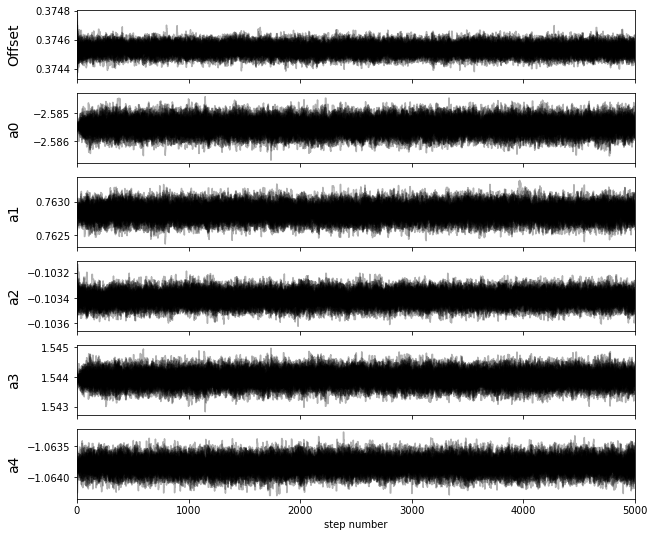

In [21]:
fig, axes = plt.subplots(len(solnx), figsize=(10, 1.5*len(solnx)), sharex=True)
samples = sampler.get_chain()
labels = ["Offset","a0", "a1", "a2", "a3",
          "a4"]#, "a5", "a6", "a7", "a8"]
#["Jitterpar","Offset","a0", "a1", "a2", "a3",
#         "a4", "a5", "a6", "a7", "a8"]
#labels = ["Amplitude", "Jitterpar","Offset", "a0", "a1", "a2", "a3",
#          "a4", "a5", "a6", "a7", "a8", "a9", "a10", "a11", "a12"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], size=14)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [23]:
# discard first 100 burn-in samples
flat_samples = sampler.get_chain(discard=2000, thin=15, flat=True)



In [24]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

print("Chi-Sq coeffs: "+str(a_coeff))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Chi-Sq coeffs: [ 0.37453246 -2.5854755   0.76284255 -0.10340277  1.54395907 -1.06380613]


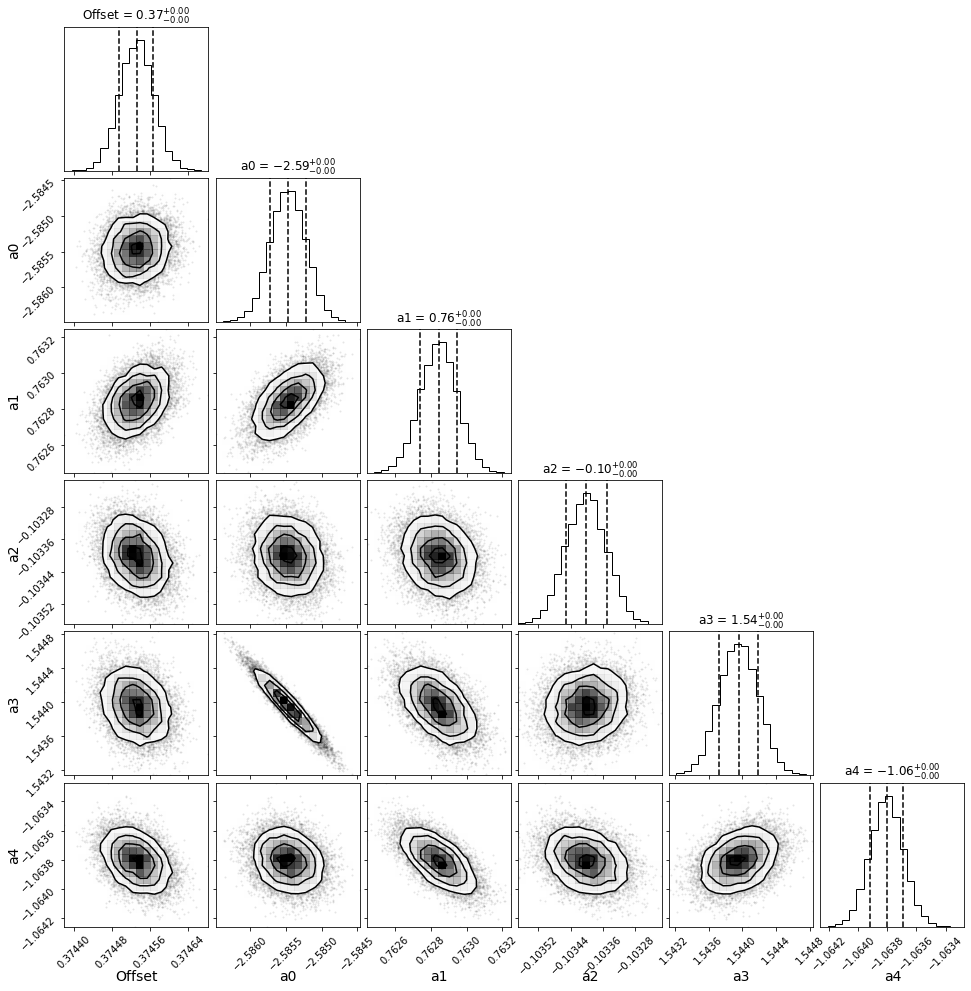

In [25]:
import corner
fig = corner.corner(
    flat_samples,
    labels=labels,
    quantiles=[0.159, 0.5, 0.841],
    show_titles=True,
    label_kwargs=dict(fontsize=14))

a_coeff: [ 0.37453246 -2.5854755   0.76284255 -0.10340277  1.54395907 -1.06380613]
A_mcmc_coeffs: [ 0.37453207 -2.58546934  0.76284399 -0.10340196  1.54395706 -1.06380532]


Text(0.5, 1.0, 'Binned mcmc fit: 10700')

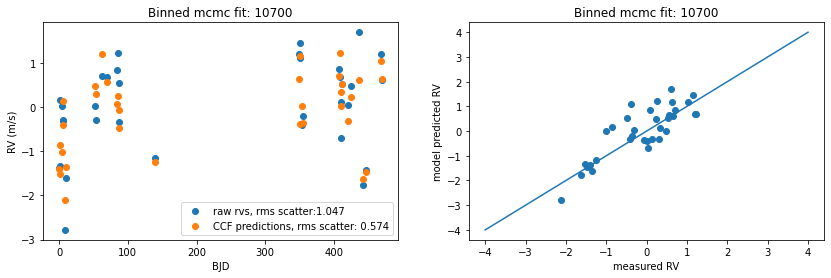

In [26]:
D_mcmc = np.percentile(flat_samples[:, 0], [50])[0]

All_mcmc_coeffs = np.zeros(len(a_coeff))
for i in np.arange(0, len(a_coeff)):
    All_mcmc_coeffs[i]=  np.percentile(flat_samples[:, i], [50])[0]

print('a_coeff: '+str(a_coeff))
print('A_mcmc_coeffs: '+str(All_mcmc_coeffs))
y_preds = D_mcmc + CCF_matrix.dot(All_mcmc_coeffs[1:])#(A_mcmc_coeffs)

fig, ax = plt.subplots(1,2, figsize=(14, 4))
ax[0].scatter(time_np, y, label="raw rvs, rms scatter:"+str(round(np.std(y, ddof=1),3)))
ax[0].scatter(time_np, y_preds, label="CCF predictions, rms scatter: "+str(round(np.std(y-y_preds,ddof=1),3)))
ax[0].set_ylabel("RV (m/s)")
ax[0].set_xlabel("BJD")
ax[0].set_title("Binned mcmc fit: "+star_name)
ax[0].legend()


ax[1].scatter(y_preds, y)
ax[1].plot([-4,4],[-4,4])
ax[1].set_xlabel("measured RV")
ax[1].set_ylabel("model predicted RV")
ax[1].set_title("Binned mcmc fit: "+star_name)

In [154]:
# compute log-likelhoods

# mcmc fit
mcmc_log_likelihood = log_likelihood(All_mcmc_coeffs
                                     ,time_np, CCF_matrix, y, yerr)
print("mcmc_log_likelihood: "+str(mcmc_log_likelihood))


LS_log_likelihood = log_likelihood(a_coeff,time_np, CCF_matrix, y, yerr)
print("LS_log_likelihood: "+str(LS_log_likelihood))

mcmc_log_likelihood: -208807554.67509225
LS_log_likelihood: -208807554.67082506


In [700]:
np.std(y-y_preds,ddof=1)

0.5597366551443247

In [338]:
np.std(y, ddof=1)

1.9953064054798533

## Genetic Algorithm for CCF Index Optimization


In [ ]:
# Genetic Algorithm to find the optimal ccf params

possible_indexes = np.arange(295, 410)#np.arange(0, len(ccf_list_np[0])-1)
ccf_indexes = [306, 347, 357, 367, 406]#, 368, 401, 500, 600]
best_indexes =[306, 347, 357, 367, 406]#, 368, 401, 500, 600]
best_rms = np.std(y, ddof=1) #m/s

print(str(round(best_rms,3))+", og indexes: "+str(best_indexes))

jumps = 0
while jumps <100000:
    # Choose the random index to replace in the ccf
    rand_index = np.random.randint(0, len(ccf_indexes))
    a = ccf_indexes[0:rand_index]
    b = ccf_indexes[rand_index+1:]
    remainder_indexes = np.concatenate((a, b))
    
    # Choose what index to replace it with
    new_ccf_loc = np.random.choice(possible_indexes)
    
    # check whether this index already exists in the array. If it does, it assigns a new one until it does not exist in the array anymore
    while new_ccf_loc in ccf_indexes or any(x in (np.abs(np.array(remainder_indexes)-new_ccf_loc)) for x in [0,1,2, 3]):
        new_ccf_loc = np.random.choice(possible_indexes)
    
    #while 2 in np.abs(np.array(ccf_indexes)-new_ccf_loc):
    #    new_ccf_loc = np.random.choice(possible_indexes)
    
    #print(str(rand_index)+", "+str(new_ccf_loc))
    
    # replace it
    ccf_indexes[rand_index] = new_ccf_loc
    
    # perform the L-S fit --------------
    a_coeff, y_preds, CCF_matrix, og_rms, new_rms = Weighted_LS_fit(ccf_indexes, ccf_list_np, 
                                                     ccf_list_np_transpose,rv_np, s_rv_np)
    
    # Evaluate the L-S fit --------------
    jumps +=1
    # check whether the new rms is lower than the previously best rms
    if new_rms < best_rms:
        best_indexes[rand_index] = new_ccf_loc
        best_rms = new_rms
        ccf_indexes = best_indexes.copy()
        #print(", best indexes: "+str(best_indexes))
        print("jump: "+str(jumps)+str(round(new_rms,3))+", best indexes: "+str(best_indexes)+", a_coeff: "+str(a_coeff))
    else: #rms is not lower
        # resets the ccf_indexes back to the previously best ones
        ccf_indexes = best_indexes.copy()
        #print("WORSE: "+str(round(new_rms,3))+", ccf indexes: "+str(ccf_indexes))
        #print(", best indexes: "+str(best_indexes))
        #continue

print(str(round(best_rms,3))+", best indexes: "+str(best_indexes))